In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [3]:
import os 

path = r"C:\Users\52444\.cache\kagglehub\datasets\asaniczka\uk-optimal-product-price-prediction\versions\3"

os.listdir(path)

['amz_uk_price_prediction_dataset.csv']

In [4]:

df = pd.read_csv(
    r"C:\Users\52444\.cache\kagglehub\datasets\asaniczka\uk-optimal-product-price-prediction\versions\3\amz_uk_price_prediction_dataset.csv"
)


In [5]:
df.head()
df.shape
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2443651 entries, 0 to 2443650
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   uid                int64  
 1   asin               object 
 2   title              object 
 3   stars              float64
 4   reviews            int64  
 5   price              float64
 6   isBestSeller       bool   
 7   boughtInLastMonth  int64  
 8   category           object 
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 151.5+ MB


In [6]:
#FILTRANDO COLUMNAS QUE TENGAN MAS DEL 80% PERDIDO
df = df[df.columns[df.isnull().mean() < 0.8]]

In [7]:
df.columns

Index(['uid', 'asin', 'title', 'stars', 'reviews', 'price', 'isBestSeller',
       'boughtInLastMonth', 'category'],
      dtype='object')

In [8]:
#REMOVIENDO EL ID DE LAS COLUMNAS DEL DATAFRAME
df.drop("uid", inplace=True, axis=1)

In [9]:
#CROSSTAB PARA SABER CUALES PRODUCTOS EN CADA CATEGORIA SON LOS MEJORES VENDIDOS CONTRA LOS QUE NO LO SON

crosstab = pd.crosstab(df['category'], df['isBestSeller'])
crosstab

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


In [10]:
#AUNQUE ES UN POCO CONFUSO, DENTRO DE CADA CATEGORIA LOS PRODUCTOS QUE NO SON BEST SELLER SE ENCUENTRAN EN EL RANGO DE (FALSE) Y LOS QUE SI SON BEST SELLER (TRUE).
#REVISANDO LA PROPORCION, UN APRODUCTO WOMEN TIENE 3X MAS PROBABILIDADES DE SER BEST SELLER QUE UNO DE 3D PRINTERS

In [11]:
#MEJOR VENDIDOS POR CATEGORIA 
prop_crosstab = pd.crosstab(
    df['category'],
    df['isBestSeller'],
    normalize='index'
)

prop_crosstab


isBestSeller,False,True
category,,
3D Printers,0.995968,0.004032
3D Printing & Scanning,0.999508,0.000492
Abrasive & Finishing Products,0.980000,0.020000
Action Cameras,0.999411,0.000589
Adapters,0.988189,0.011811
...,...,...
Wind Instruments,0.972000,0.028000
Window Treatments,0.979079,0.020921
Women,0.988015,0.011985


In [14]:
#PRUEBAS ESTADISTICAS 

import pandas as pd
from scipy.stats import chi2_contingency

# Tabla de contingencia
contingency_table = pd.crosstab(df['category'], df['isBestSeller'])

# Chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

chi2, p_value



(np.float64(36540.20270061387), np.float64(0.0))

¿BestSeller es independiente de category?

p-value < 0.05 
El estatus de best-seller sí depende de la categoría

p-value ≥ 0.05 → no hay evidencia suficiente de dependencia


In [15]:
#Cramer´s V

import numpy as np

n = contingency_table.values.sum()
min_dim = min(contingency_table.shape) - 1

cramers_v = np.sqrt(chi2 / (n * min_dim))
cramers_v


np.float64(0.1222829439760564)

Con la prueba de chi-cuadrado descartamos hipótesis nula de independencia (p < 0,05), esto indica que el éxito de las ventas no es independiente de la categoría del producto. Sin embargo, la V de Cramér nos arroja que la categoría sí influye en la probabilidad de éxito de ventas.

In [16]:
#VISUALIZACION

# Crosstab normalizado por fila 
ct_prop = pd.crosstab(
    df['category'],
    df['isBestSeller'],
    normalize='index'
)

# Opcional: ordenar por proporción de best-sellers
ct_prop = ct_prop.sort_values(True, ascending=False)

ct_prop.head()



isBestSeller,False,True
category,,
Grocery,0.941865,0.058135
Smart Home Security & Lighting,0.942308,0.057692
Health & Personal Care,0.942314,0.057686
Mobile Phone Accessories,0.957529,0.042471
Power & Hand Tools,0.964661,0.035339


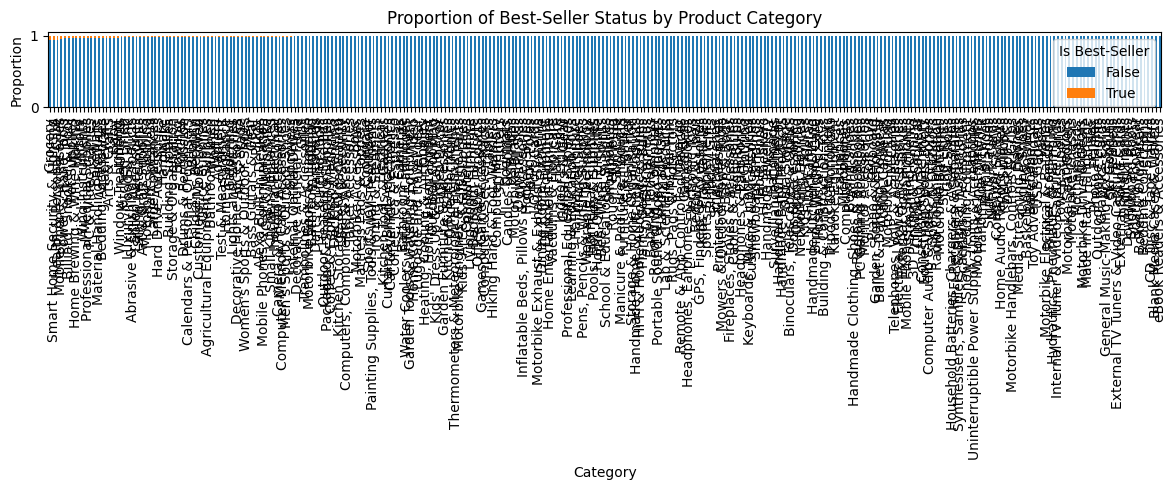

In [17]:

ct_prop.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 5)
)

plt.title('Proportion of Best-Seller Status by Product Category')
plt.ylabel('Proportion')
plt.xlabel('Category')
plt.legend(title='Is Best-Seller')
plt.tight_layout()
plt.show()


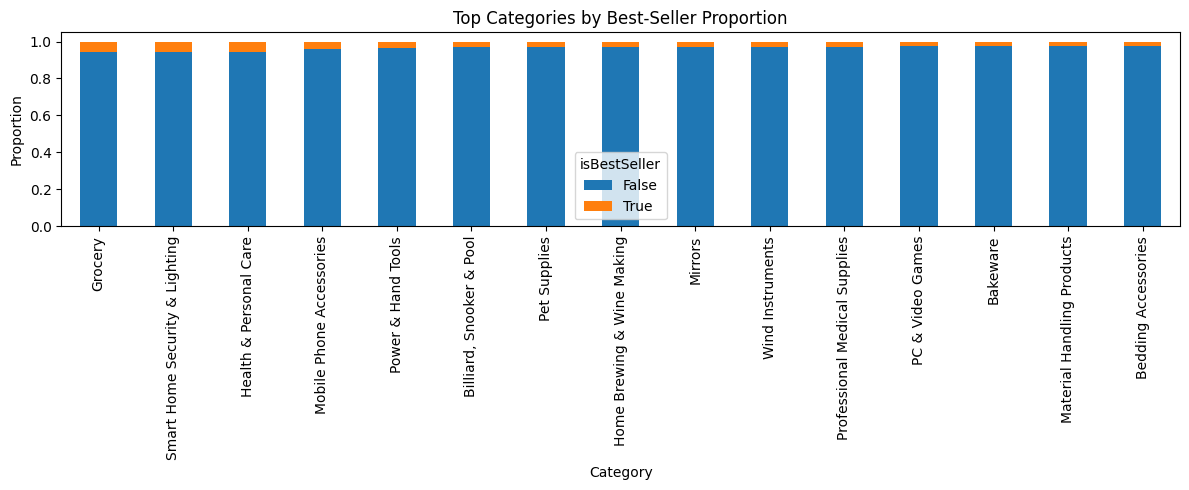

In [18]:
#disminuyendo valores 
top_categories = ct_prop.head(15)

top_categories.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 5)
)

plt.title('Top Categories by Best-Seller Proportion')
plt.ylabel('Proportion')
plt.xlabel('Category')
plt.tight_layout()
plt.show()


#PART 2


RANGO INTERCUALITICO 
Tengo que definir el "rango normal" de los precios

precio < Q1 − 1.5 × RIQ
precio > Q3 + 1.5 × RIQ

In [19]:
#CALCULAR CUARTIOLES Y RIQ
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
RIQ = Q3 - Q1
print(RIQ)

36.0


In [20]:
#DEFINIR LIMITES
lower_bound = Q1 - 1.5 * RIQ
upper_bound = Q3 + 1.5 * RIQ


In [21]:
#FILTRAR EL DATA
df_no_outliers = df[
    (df['price'] >= lower_bound) &
    (df['price'] <= upper_bound)
]


VIOLIN PLOT PRICE POR CATEGORY
TOP 20 CATEGORIAS MAS FRECUENTES 

In [22]:

top_categories = (
    df['category']
    .value_counts()
    .head(20)
    .index
)

df_top20 = df[df['category'].isin(top_categories)]

In [23]:
df.columns

Index(['asin', 'title', 'stars', 'reviews', 'price', 'isBestSeller',
       'boughtInLastMonth', 'category'],
      dtype='object')

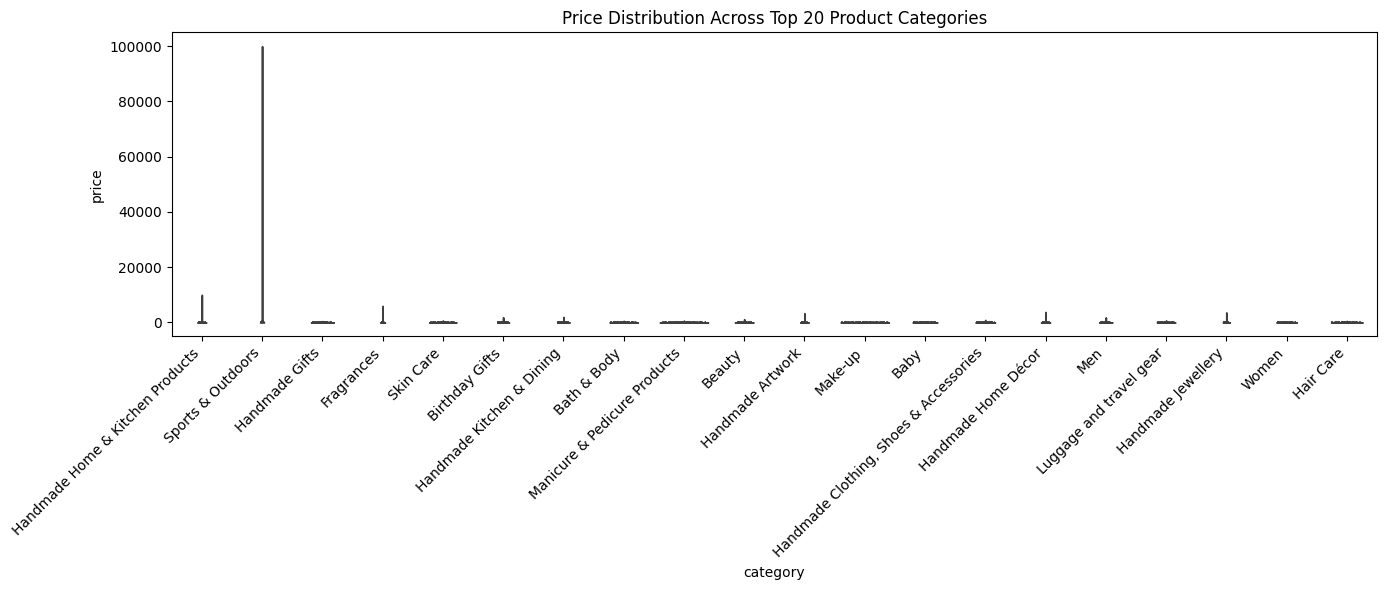

In [24]:
#VIOLIN PLOT 

plt.figure(figsize=(14, 6))

sns.violinplot(
    data=df_top20,
    x='category',
    y='price',
    inner='quartile',   # muestra mediana y cuartiles
    cut=0               
)

plt.xticks(rotation=45, ha='right')
plt.title('Price Distribution Across Top 20 Product Categories')
plt.tight_layout()
plt.show()


El producto con el precio mas elevado por categoria es deportes y actividades al aire libre (Sports & Outdoors)

BAR CHART CON COPMPARACION DE PRECIO PROMEDIO DEL TOP 10 DE CATEGORIAS PRINCIPALES

In [26]:
#cuales son los productos dentro del top 10 
top10_categories = (
    df['category']
    .value_counts()
    .head(10)
    .index
)

df.head(10)

,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers
5,B09B97WSLF,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
6,B09B9615X2,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
7,B01MTB55WH,Anker Soundcore 2 Portable Bluetooth Speaker w...,4.7,103673,39.99,False,0,Hi-Fi Speakers
8,B016MO90GW,"Bluetooth Speaker, Anker Soundcore Speaker Upg...",4.7,29909,29.99,False,0,Hi-Fi Speakers
9,B09ZQF5GZW,RIENOK Bluetooth Speaker Portable Wireless Blu...,4.5,16014,29.99,False,0,Hi-Fi Speakers


In [27]:
#calcular el precio medio para las categorias 
avg_price_top10 = (
    df[df['category'].isin(top10_categories)]
    .groupby('category')['price']
    .mean()
    .sort_values(ascending=False)
)


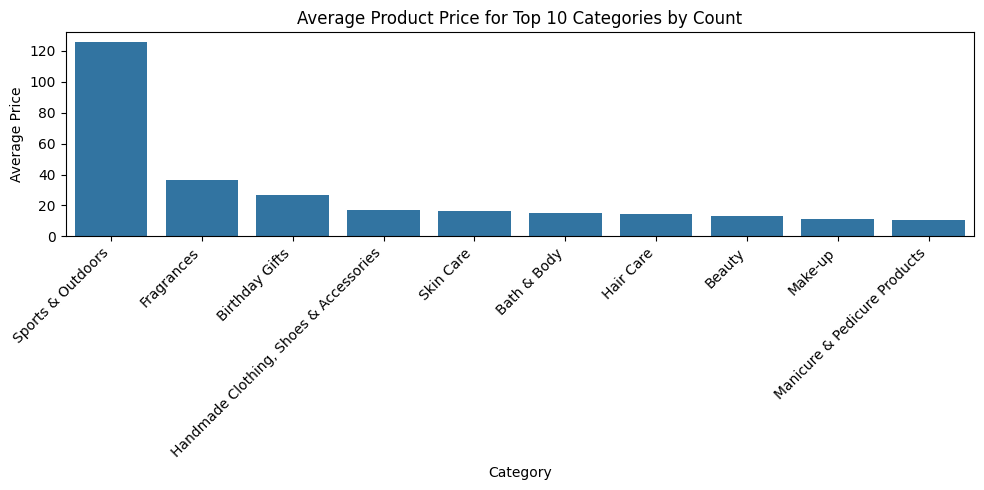

In [28]:
#BAR CHART 
plt.figure(figsize=(10, 5))

sns.barplot(
    x=avg_price_top10.index,
    y=avg_price_top10.values
)

plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Price')
plt.xlabel('Category')
plt.title('Average Product Price for Top 10 Categories by Count')
plt.tight_layout()
plt.show()


In [30]:
#Categoria con el precio más alto sin filtrar
mean_price_by_category = (
    df.groupby('category')['price']
      .mean()
      .sort_values(ascending=False)
)

mean_price_by_category.head(1)


category
Laptops    1087.987827
Name: price, dtype: float64

Nota: En este caso, las categorias con los precios más altos no coinciden con el bar chart, esto puede deberse a:

suelen tener pocos productos, tienen precios más accesibles ó más competencia

BOX PLOTS Y LA DISTRIBUCION DE RATINGS PO RCATEGORY 



In [31]:
#seleccion del top 10 de categorias mas frecuentes 
top10_categories = (
    df['category']
    .value_counts()
    .head(10)
    .index
)

df_top10 = df[df['category'].isin(top10_categories)]


In [33]:
df.columns


Index(['asin', 'title', 'stars', 'reviews', 'price', 'isBestSeller',
       'boughtInLastMonth', 'category'],
      dtype='object')

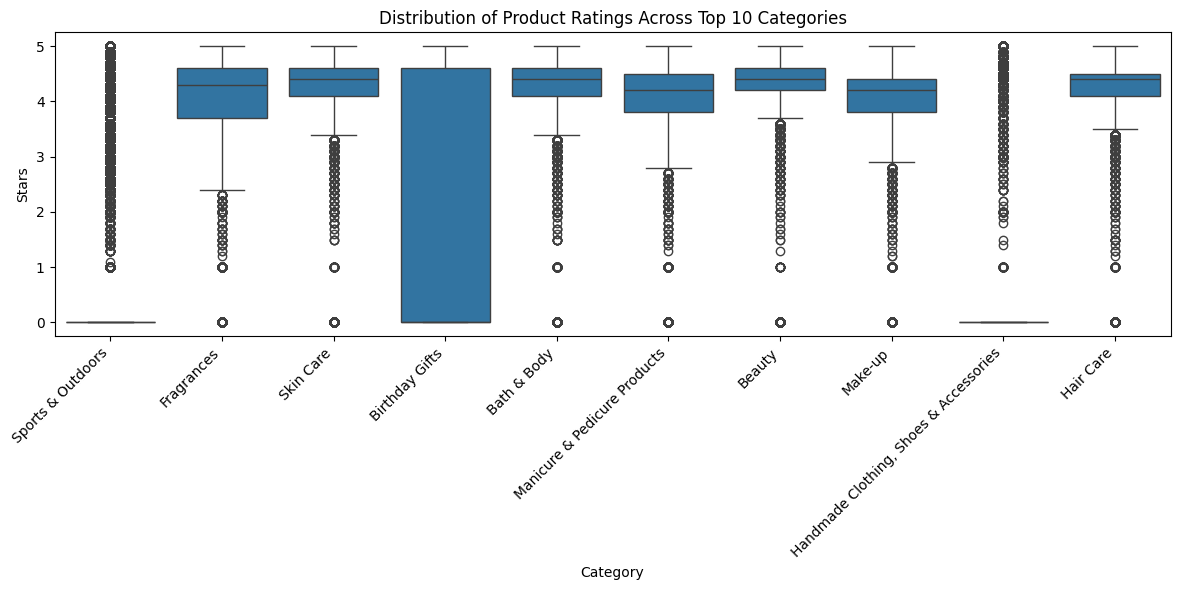

In [34]:
#BOX PLOT 

plt.figure(figsize=(12, 6))

sns.boxplot(
    data=df_top10,
    x='category',
    y='stars'
)

plt.xticks(rotation=45, ha='right')
plt.xlabel('Category')
plt.ylabel('Stars')
plt.title('Distribution of Product Ratings Across Top 10 Categories')
plt.tight_layout()
plt.show()


In [36]:
#CATEGORIA CON LA MEDIANA MAS ALTA 
median_rating_by_category = (
    df.groupby('category')['stars']
      .median()
      .sort_values(ascending=False)
)

median_rating_by_category.head(10)


category
Computer Memory                 4.7
CPUs                            4.6
Building & Construction Toys    4.6
Laptop Accessories              4.6
Hobbies                         4.6
Kids' Play Figures              4.6
Beer, Wine & Spirits            4.6
Office Paper Products           4.6
Luxury Food & Drink             4.6
Children's Bedding              4.5
Name: stars, dtype: float64

PARTE 3  
INTERACCION ENTRE PRECIOS Y CALIFICACIONES 

In [37]:
#COEFICIENTE DE RELACION ENTRE PRECIO Y ESTRELLAS O CALIFICACION 

corr_price_stars = df['price'].corr(df['stars'], method='pearson')
corr_price_stars


np.float64(-0.12490673262148638)

In [38]:
#No hay una relacion siginifcativa entre precio y rating, los productos mascaros no siempre son los mejor valorados y visceversa.

In [ ]:
#VISUALIZACION 

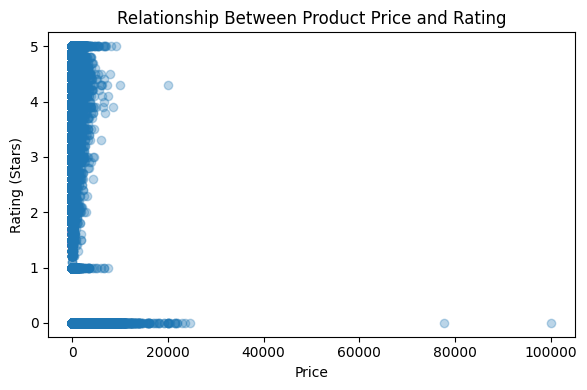

In [39]:

plt.figure(figsize=(6, 4))

plt.scatter(
    df['price'],
    df['stars'],
    alpha=0.3
)

plt.xlabel('Price')
plt.ylabel('Rating (Stars)')
plt.title('Relationship Between Product Price and Rating')
plt.tight_layout()
plt.show()


No se puede observar ni apreciar ninguna relacion clara entre el precio y la valoracion del producto 

In [40]:
#HEATMAP DE CORRELACIONES 

numeric_df = df.select_dtypes(include=np.number)

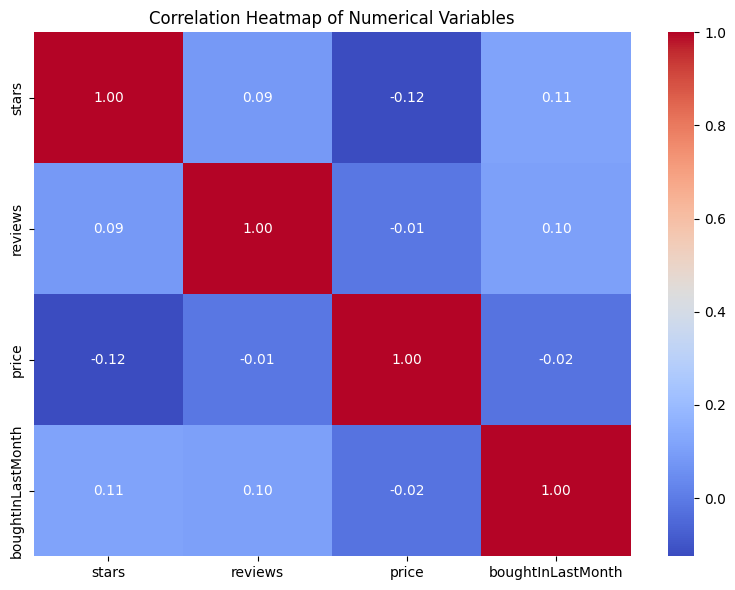

In [41]:
corr_matrix = numeric_df.corr()

plt.figure(figsize=(8, 6))

sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f'
)

plt.title('Correlation Heatmap of Numerical Variables')
plt.tight_layout()
plt.show()


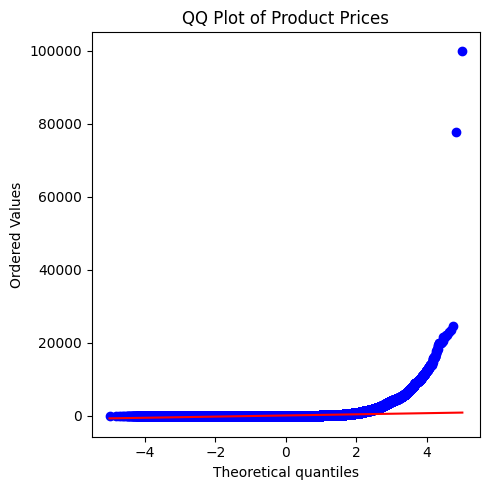

In [43]:
#QQplot, distribucion del precio 
import scipy.stats as stats

plt.figure(figsize=(5, 5))

stats.probplot(df['price'], dist="norm", plot=plt)

plt.title('QQ Plot of Product Prices')
plt.tight_layout()
plt.show()


Aunque los puntos inicialmente siguen una linea diagonal, finalmente no siguen una distrucion normal 

In [ ]:
#BONUS

#Si se hace una verificacion para ver si existen cambios en el Data original sin outliers no se ve gran diferencia en correlacion, esta sigue siendo muy baja, estos resultados no dependen del filtrado solo hacen que las visualizaciopnes sean menos interpretables ya que estos mismos dominan el cuadro